<h1>
    Thermodynamics of Materials AD19: <br>
    <b>Class Activity 03</b>
</h1>

<table width="75%" align="center">
    <tr>
        <th align="left" colspan="2">
            <h2><b>Team<b>:</b></h2>
        </th>
    </tr>
    <tr>
        <td><h3>Antonio Osamu Katagiri Tanaka</h3></td>
        <td><h4>A01212611@itesm.mx</h4></td>
    </tr>
</table>

---

<h1>Binary Phase Diagrams</h1>

In [1]:
# PYTHON LIBRARIES
%matplotlib inline

import numpy as np
np.seterr(divide='ignore', invalid='ignore')
import pandas as pd
import matplotlib.pyplot as plt
plt.rc('xtick', labelsize=15)     
plt.rc('ytick', labelsize=15)

from scipy.optimize import least_squares, fsolve, curve_fit

$$ \Delta G_{m,A} = 8000 - 10 T [J/mol] $$
$$ \Delta G_{m,B} = 12000 - 10 T [J/mol] $$

In [2]:
def DG_mA_(T):
    return 8000 - 10*T;

def DG_mB_(T):
    return 12000 - 10*T;

$$ \Omega_l = -20000 [J/mol] $$
$$ \Omega_s = 0 [J/mol] $$

In [3]:
Omega_l = -20000
Omega_s = 0

$$ \Delta G_s = - x_A \Delta G_{m,A} + R T (x_A ln x_A + x_B ln x_B) + \Omega_s x_A x_B  $$
$$ \Delta G_l = x_B \Delta G_{m,B} + R T (x_A ln x_A + x_B ln x_B) + \Omega_l x_A x_B $$

$$ G_{B,s} = 0 $$
$$ G_{A,l} = 0 $$

Substituing numerical values ...

$$ \Delta G_s = R T (x_A ln x_A + x_B ln x_B) $$
$$ \frac{d \Delta G_s}{d x_B} = R T (ln x_B - ln(1 - x_B)) $$

$$ \Delta G_l = (12000 - 10 T) x_B + (8000 - 10 T) * x_A + R T (x_A ln x_A + x_B ln x_B) - 20000 x_A x_B $$
$$ \frac{d \Delta G_l}{d x_B} = 4000 - 20000*(1 - x_B) + 20000 x_B + R T (ln x_B - ln(1 - x_B)) $$

In [4]:
def DG_s_(xb, T):
    R = 8.3144
    xa = 1 - xb
    return R*T*(xa*np.log(xa) + xb*np.log(xb))

def d_DG_s_(xb, T):
    R = 8.3144
    return R*T*(np.log(xb) - np.log(1 - xb))


def DG_l_(xb, T):
    R = 8.3144
    xa = 1 - xb
    return (12000 - 10*T)*xb + (8000 - 10*T)*xa + R*T*(xa*np.log(xa) + xb*np.log(xb)) - 20000*xa*xb

def d_DG_l_(xb, T):
    R = 8.3144
    return 4000 - 20000*(1-xb) + 20000*xb + R*T*(np.log(xb) - np.log(1 - xb))

The tangents are depicted as:

```python
    y_tan_l = d_DG_l_(xl0, T) * (xb - xl0) + DG_l_(xl0, T, Omega_l)
    y_tan_s = d_DG_s_(xs0, T) * (xb - xs0) + DG_s_(xs0, T, Omega_s)
```

$$ y_{tan,l}(x_B) = [4000 - 20000*(1 - x_{l,0}) + 20000 x_{l,0} + R T (ln x_{l,0} - ln(1 - x_{l,0}))]*[x_B - x_{l,0}] + [(12000 - 10 T) x_{l,0} + (8000 - 10 T) * (1 - x_{l,0}) + R T ((1 - x_{l,0}) ln (1 - x_{l,0}) + x_{l,0} ln x_{l,0}) - 20000 x_A x_B] $$
$$ y_{tan,l}(x_B) = 4000 (2 - 4 x_B + 10 x_B x_{l,0} - 5 {x_{l,0}}^2) - 10 T - (x_B - 1) R T ln(1 - x_{l,0}) + (2x_B - x_{l,0}) R T lnx_{l,0} $$

$$ y_{tan,s}(x_B) = [R*T*(ln(x_{s,0}) - ln(1 - x_{s,0}))]*[x_B - x_{s,0}] + [R*T*((1 - x_{s,0})*ln(1 - x_{s,0}) + xb*ln(x_{s,0}))] $$
$$ y_{tan,s}(x_B) = R T ( - (x_B - 1) ln(1 - x_{s,0}) + (2 x_B - x_{s,0}) ln x_{s,0}) $$

Find the common tangent(s), $y_{tan,l} = y_{tan,s}$ at $x_B = 0$. So, let's find some $x_{l,0}$ and $x_{s,0}$ to satisfy that.
$$ y_{tan,l}(0) = 4000 (2 - 5 {x_{l,0}}^2) - 10 T + R T ln(1 - x_{l,0}) - x_{l,0} R T lnx_{l,0} $$
$$ y_{tan,s}(0) = R T (ln(1 - x_{s,0}) - x_{s,0} lnx_{s,0}) $$

---
Get compositions in equilibrium from a given temperature

In [5]:
def phaseDiagram(T):
    #y_tan_l = d_DG_l_(xl0, T) * (xb - xl0) + DG_l_(xl0, T)
    #y_tan_s = d_DG_s_(xs0, T) * (xb - xs0) + DG_s_(xs0, T)

    f1 = lambda x: DG_l_(x, T)
    df1 = lambda x: d_DG_l_(x, T)
    f2 = lambda x:  DG_s_(x, T)
    df2 = lambda x: d_DG_s_(x, T)

    def eqns(x):
        x1, x2 = x[0], x[1]
        eq1 = df1(x1) - df2(x2)
        eq2 = df1(x1)*(x1 - x2) - (f1(x1) - f2(x2))
        return [eq1, eq2]

    from scipy.optimize import least_squares
    lowerbound = 0.0000001
    upperbound = 0.9999999
    lb = (lowerbound, lowerbound) # lower bounds on x1, x2
    ub = (upperbound, upperbound) # upper bounds

    x0 = least_squares(eqns, [0.1, 0.1], bounds=(lb, ub)) # liquid xs
    x1 = least_squares(eqns, [0.9, 0.9], bounds=(lb, ub)) # solid xs
    #print(x0.x, x1.x)
    return x0.x[0], x0.x[1], x1.x[0], x1.x[1]

PLOT

<module 'matplotlib.pyplot' from 'C:\\Users\\oskat\\Anaconda3\\lib\\site-packages\\matplotlib\\pyplot.py'>

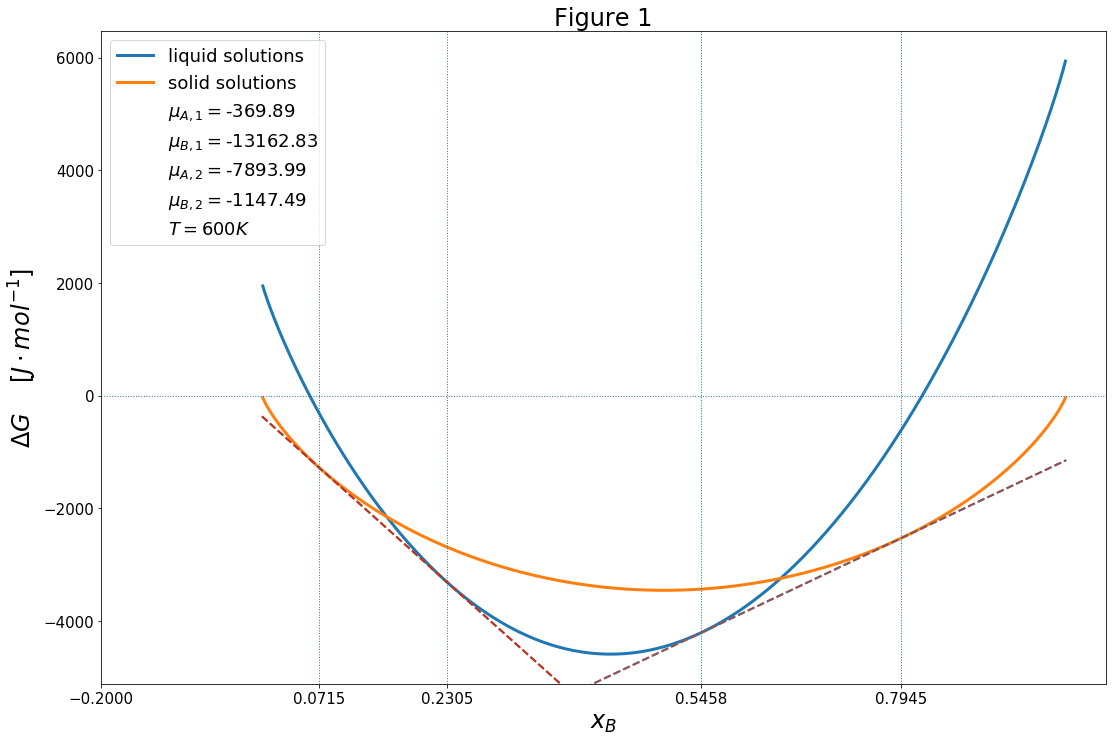

In [9]:
T = 600
xb = np.linspace(0.0, 1.0, 1000)

comp = phaseDiagram(T);

# PLOT FIG
scale = 6;
fig, ax = plt.subplots(figsize=(3*scale, 2*scale));

# Plot
#plt.scatter(T, C, s=25, color='red', label='Raw data');
x = xb
yl = DG_l_(xb, T)
plt.plot(x, yl, '-', linewidth=3, label='liquid solutions')

x = xb
ys = DG_s_(xb, T)
plt.plot(x, ys, '-', linewidth=3, label='solid solutions')

# A,}JXJJHYy*pVeM6
ax.set(autoscale_on=False)
ax.set_xticks(ax.get_xticks()[::100])
plt.axhline(y=0, linestyle=':', linewidth=1)

# plot tangents
lowerbound = 0.0000001
upperbound = 0.9999999
    
if (round(comp[0],3) > lowerbound and round(comp[1],3) < upperbound):
    # plot tangents
    y_tan_l = d_DG_l_(comp[0], T) * (xb - comp[0]) + DG_l_(comp[0], T)
    y_tan_s = d_DG_s_(comp[1], T) * (xb - comp[1]) + DG_s_(comp[1], T)
    plt.plot(x, y_tan_l, '--', linewidth=2)
    plt.plot(x, y_tan_s, '--', linewidth=2)
    # add values as ticks
    extraticks=[comp[0], comp[1]]
    plt.xticks(list(plt.xticks()[0]) + extraticks)
    plt.axvline(x=comp[0], linestyle=':', linewidth=1)
    plt.axvline(x=comp[1], linestyle=':', linewidth=1)
    # add chemical potentials as legend
    plt.scatter(xb[0], yl[0], s=0, label=r'$\mu_{A,1} = $' + str(round(y_tan_l[0], 2)))
    plt.scatter(xb[0], yl[0], s=0, label=r'$\mu_{B,1} = $' + str(round(y_tan_l[len(y_tan_l)-1], 2)))

if (round(comp[2],3) > lowerbound and round(comp[3],3) < upperbound):
    # plot tangents
    y_tan_l = d_DG_l_(comp[2], T) * (xb - comp[2]) + DG_l_(comp[2], T)
    y_tan_s = d_DG_s_(comp[3], T) * (xb - comp[3]) + DG_s_(comp[3], T)
    plt.plot(x, y_tan_l, '--', linewidth=2)
    plt.plot(x, y_tan_s, '--', linewidth=2)
    # add compositions as ticks
    extraticks=[comp[2], comp[3]]
    plt.xticks(list(plt.xticks()[0]) + extraticks)
    plt.axvline(x=comp[2], linestyle=':', linewidth=1)
    plt.axvline(x=comp[3], linestyle=':', linewidth=1)
    # add chemical potentials as legend
    plt.scatter(xb[0], yl[0], s=0, label=r'$\mu_{A,2} = $' + str(round(y_tan_l[0], 2)))
    plt.scatter(xb[0], yl[0], s=0, label=r'$\mu_{B,2} = $' + str(round(y_tan_l[len(y_tan_l)-1], 2)))

# Print fitting parameters as plot legends
plt.scatter(xb[0], yl[0], s=0, label=r'$T = $' + str(round(T, 2)) + r'$K$')

# Display plots
plt.yscale('linear');
plt.xlabel(r'$x_B$', fontsize=24);
plt.ylabel(r'$\Delta G$' + '    ' + r'$[J \cdot mol^{-1}]$', fontsize=24);
plt.title('Figure 1', size=24);
plt.legend(prop={'size': 18});
display(plt);

In [74]:
'''
from sympy import symbols, Eq, solve
from sympy.functions import log as smlog

a, c = symbols('a c')

eq1 = Eq(8.3144*T*(smlog(c) - smlog(1 - c)) - 10*T + 8000)
eq2 = Eq(8.3144*T*(smlog(a) - smlog(1 - a)) - 20000*(1 - a) + 20000*a - 10*T + 12000)

sol = solve((eq1, eq2),(a, c))
sol
'''

"\nfrom sympy import symbols, Eq, solve\nfrom sympy.functions import log as smlog\n\na, c = symbols('a c')\n\neq1 = Eq(8.3144*T*(smlog(c) - smlog(1 - c)) - 10*T + 8000)\neq2 = Eq(8.3144*T*(smlog(a) - smlog(1 - a)) - 20000*(1 - a) + 20000*a - 10*T + 12000)\n\nsol = solve((eq1, eq2),(a, c))\nsol\n"

In [75]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import fsolve

# Define the expression whose roots we want to find

R = 8.3144
#xa = 1 - xb
T = 600
func = lambda x0 : (d_DG_l_(xl0, T) * (xb - xl0) + DG_l_(xl0, T)) - (d_DG_s_(xs0, T) * (xb - xs0) + DG_s_(xs0, T))

tau_initial_guess = 0.5
tau_solution = fsolve(func, tau_initial_guess)

tau_solution

array([0.4])

 active_mask: array([0, 0])
        cost: 5.169878828456423e-25
         fun: array([ 9.09494702e-13, -4.54747351e-13])
        grad: array([ 6.14827422e-08, -2.77909753e-08])
         jac: array([[ 6.01231613e+04, -3.05565004e+04],
       [-1.49556574e+04,  2.13623047e-04]])
     message: '`xtol` termination condition is satisfied.'
        nfev: 9
        njev: 9
  optimality: 3.35546358579927e-08
      status: 3
     success: True
           x: array([0.54576698, 0.79451734])